In [1]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os

import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation , Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split
import tqdm
import shutil

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [3]:
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as train_zip:
    train_zip.extractall('.')  
filenames = os.listdir("../working/train/")
labels = [x[:3] for x in filenames]
data = pd.DataFrame({"filename": filenames, "label": labels})
data.head()

,filename,label
0,dog.1302.jpg,dog
1,dog.7609.jpg,dog
2,dog.6619.jpg,dog
3,dog.1796.jpg,dog
4,cat.7889.jpg,cat


In [4]:
data['label'].value_counts()

dog    12500
cat    12500
Name: label, dtype: int64

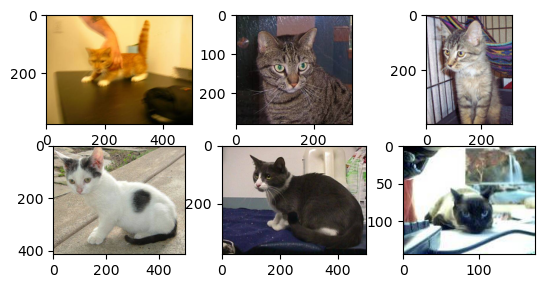

In [5]:
for i in range(6):
    plt.subplot(330 + 1 + i) # Define the subplot
    filename = '../working/train/' + 'cat.' + str(i) + '.jpg' # get the filename
    image = imread(filename) 
    plt.imshow(image) # plot the row pixel data

        
plt.show()

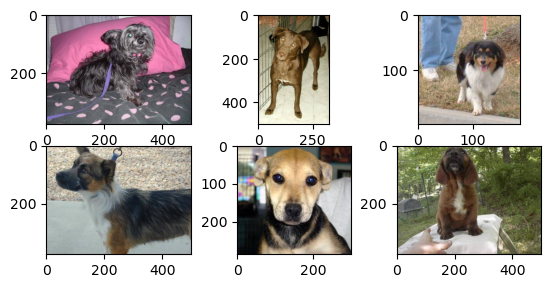

In [6]:
for i in range(6):
    plt.subplot(330 + 1 + i) # Define the subplot
    filename = '../working/train/' + 'dog.' + str(i) + '.jpg' # get the filename
    image = imread(filename) # image pixels
    plt.imshow(image) # plot the row pixel data

In [7]:
X_train, X_temp = train_test_split(data, test_size = 0.2, stratify = data['label'], random_state = 5)

X_test, X_val = train_test_split(X_temp, test_size = 0.5, stratify = X_temp['label'], random_state = 5)

print ('X_train:', X_train['label'].value_counts())

print ('X_val:', X_val['label'].value_counts())

print ('X_test:', X_test['label'].value_counts())

X_train: cat    10000
dog    10000
Name: label, dtype: int64
X_val: cat    1250
dog    1250
Name: label, dtype: int64
X_test: dog    1250
cat    1250
Name: label, dtype: int64


In [8]:
batch_size = 20
size = (150, 150)
idg = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [9]:
train_idg = idg.flow_from_dataframe(X_train, "train/", x_col = "filename", y_col = "label",
                                    batch_size = batch_size,
                                    target_size = size, shuffle = True, class_mode = 'binary')

Found 20000 validated image filenames belonging to 2 classes.


In [10]:
val_idg = idg.flow_from_dataframe(X_val, "train/", x_col = "filename", y_col = "label",
                                  batch_size = batch_size,
                                  target_size = size, shuffle = False, class_mode = 'binary')

Found 2500 validated image filenames belonging to 2 classes.


In [11]:
test_idg = idg.flow_from_dataframe(X_test, "train/", x_col = "filename", y_col = "label",
                                    batch_size = batch_size,
                                    target_size = size, shuffle = False, class_mode = 'binary')

Found 2500 validated image filenames belonging to 2 classes.


In [12]:
model = Sequential([
    Conv2D(32,(3,3),activation = 'relu',input_shape =(150,150,3)),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Dropout(0.5),
    
    Conv2D(64,(3,3),activation = 'relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Dropout(0.5),
    
    Conv2D(128,(3,3),activation = 'relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Dropout(0.5),
    
    Conv2D(128,(3,3),activation = 'relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Dropout(0.5),
    
    Flatten(),
    Dense(512,activation = 'relu'),
    Dense(1,activation = 'sigmoid')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 74, 74, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0

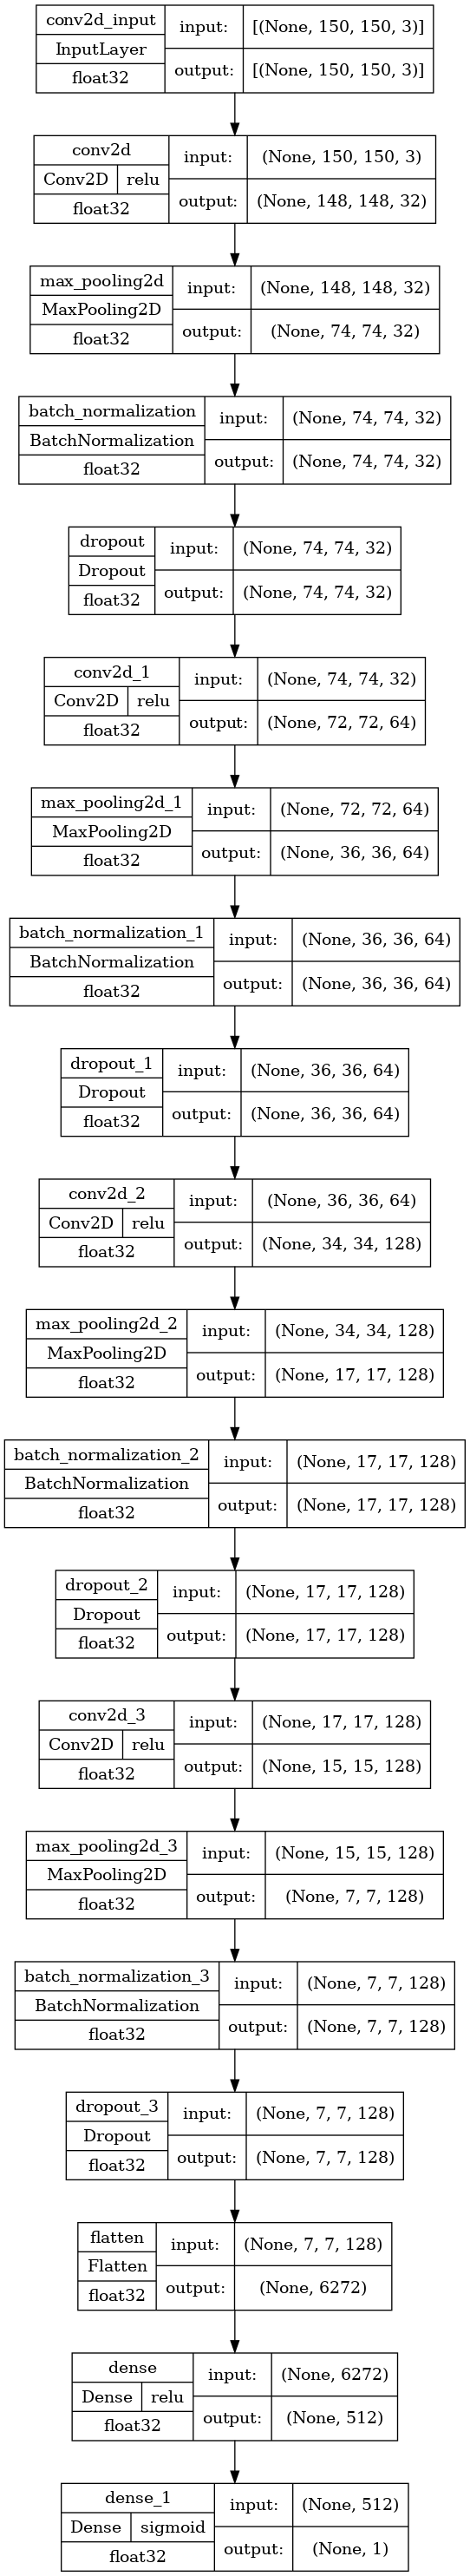

In [14]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

In [15]:
from tensorflow.keras.optimizers import Adam, RMSprop
model.compile(optimizer = RMSprop(lr=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [16]:
callback =[tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True, mode="max",patience = 4),
                tf.keras.callbacks.ModelCheckpoint("model.hdf5",
                                                monitor = "val_accuracy",
                                                save_best_only = True)]

In [17]:
history = model.fit(train_idg, batch_size=batch_size, validation_data=val_idg, epochs = 50, callbacks=[callback])

Epoch 1/50


2023-08-21 16:28:00.771478: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1000/1000 [==============================] - 59s 47ms/step - loss: 0.7979 - accuracy: 0.6533 - val_loss: 1.7940 - val_accuracy: 0.5656
Epoch 2/50
1000/1000 [==============================] - 45s 45ms/step - loss: 0.5155 - accuracy: 0.7515 - val_loss: 0.6797 - val_accuracy: 0.7240
Epoch 3/50
1000/1000 [==============================] - 45s 45ms/step - loss: 0.4615 - accuracy: 0.7885 - val_loss: 0.9569 - val_accuracy: 0.7500
Epoch 4/50
1000/1000 [==============================] - 44s 44ms/step - loss: 0.4273 - accuracy: 0.8104 - val_loss: 0.9437 - val_accuracy: 0.7200
Epoch 5/50
1000/1000 [==============================] - 45s 45ms/step - loss: 0.4068 - accuracy: 0.8239 - val_loss: 0.4647 - val_accuracy: 0.8232
Epoch 6/50
1000/1000 [==============================] - 46s 46ms/step - loss: 0.3853 - accuracy: 0.8363 - val_loss: 0.5658 - val_accuracy: 0.8280
Epoch 7/50
1000/1000 [==============================] - 46s 46ms/step - loss: 0.3683 - accuracy: 0.8460 - val_loss: 0.6367 - val_accura

In [18]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

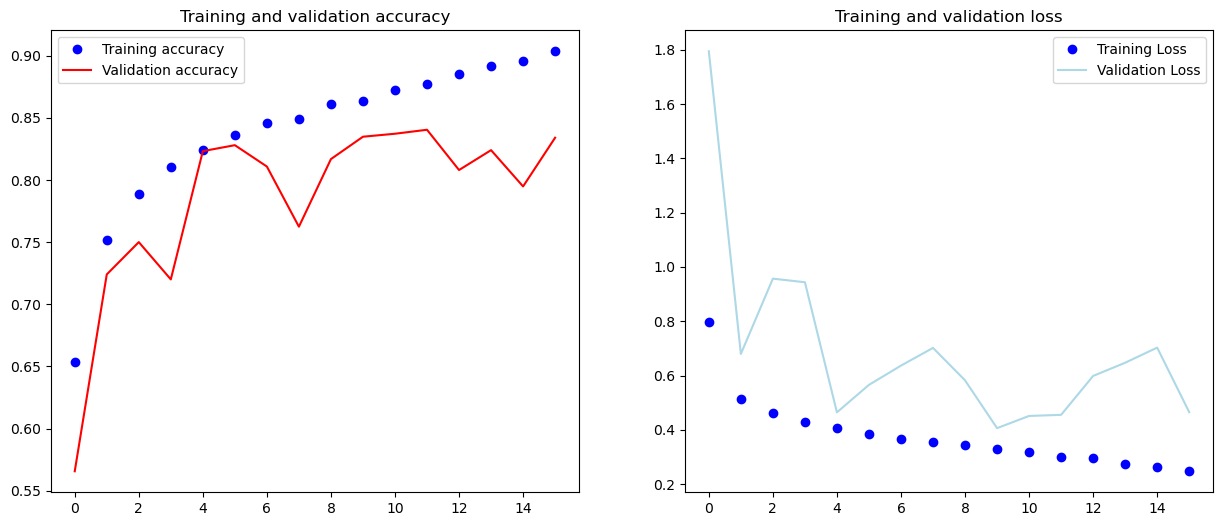

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# Plot Training accuracy on the first subplot
axes[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
axes[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
axes[0].set_title('Training and validation accuracy')

# Plot Training Loss on the second subplot
axes[1].plot(epochs, loss ,'bo', label='Training Loss')
axes[1].plot(epochs,val_loss ,label='Validation Loss',color = 'lightblue')
axes[1].set_title('Training and validation loss')
for ax in axes:
    ax.legend()
plt.show()

In [20]:
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as test1_zip:
    test1_zip.extractall('.')  
filenames = os.listdir("../working/test1/")
test_data = pd.DataFrame({"filename": filenames})
test_data['label'] = 'unknown'
test_data.head()

,filename,label
0,8107.jpg,unknown
1,10266.jpg,unknown
2,2654.jpg,unknown
3,7550.jpg,unknown
4,4656.jpg,unknown


In [21]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [22]:
test1_idg =  idg.flow_from_dataframe(test_data, "test1/", x_col= "filename",y_col = 'label',
                                    batch_size = batch_size,
                                    target_size=size, shuffle = False)

Found 12500 validated image filenames belonging to 1 classes.


In [23]:
cat_dog_model = tf.keras.models.load_model("model.hdf5")

In [24]:
test1_predict = cat_dog_model.predict(test1_idg)



625/625 [==============================] - 24s 38ms/step


In [25]:
test1_predict

array([[3.8813709e-05],
       [6.3540288e-03],
       [5.3847634e-04],
       ...,
       [2.9651161e-05],
       [1.5812923e-04],
       [4.7909979e-02]], dtype=float32)

In [26]:
test1_predict_argmax = np.round(test1_predict)

y_test_pred = test1_predict_argmax

test_data['label'] = y_test_pred

test_data.head()

,filename,label
0,8107.jpg,0.0
1,10266.jpg,0.0
2,2654.jpg,0.0
3,7550.jpg,1.0
4,4656.jpg,1.0


In [27]:
test_data.describe()

,label
count,12500.000000
mean,0.441600
std,0.496598
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [28]:
train_idg.class_indices

{'cat': 0, 'dog': 1}

In [29]:
label_mapping = {0: 'cat', 1: 'dog'}
test_data['label'] = test_data['label'].map(label_mapping)
test_data.head()

,filename,label
0,8107.jpg,cat
1,10266.jpg,cat
2,2654.jpg,cat
3,7550.jpg,dog
4,4656.jpg,dog


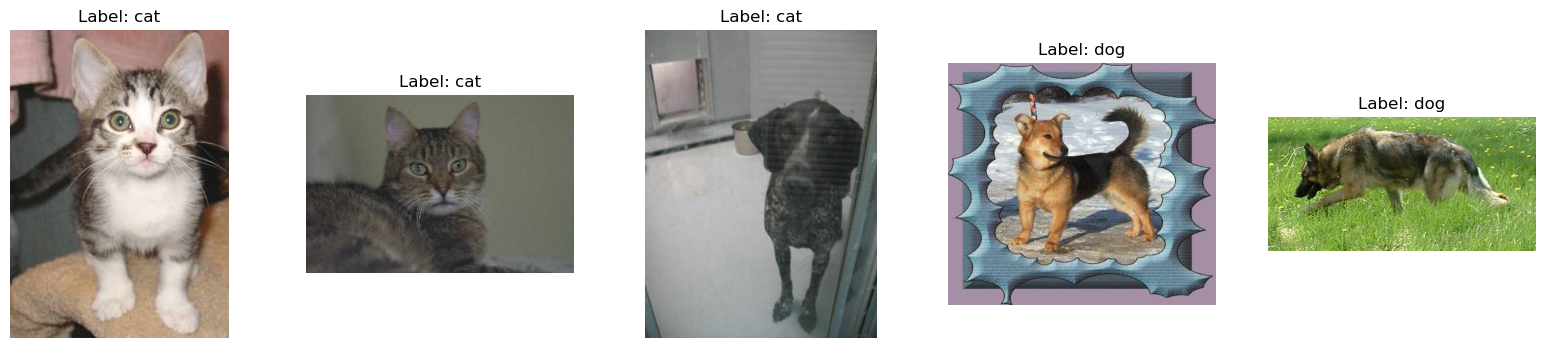

In [30]:
from PIL import Image
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx in range(5):
    image_path = os.path.join("../working/test1/", test_data.iloc[idx]['filename'])
    image = Image.open(image_path)
    axes[idx].imshow(image)
    axes[idx].set_title("Label: " + test_data.iloc[idx]['label'])
    axes[idx].axis('off')
plt.show()

In [31]:
test_data.to_csv('submission.csv', index = False)